In [1]:
%pip install pillow
import sys
from PIL import Image
sys.modules['Image'] = Image 
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = .2)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = .2)

training_set = train_datagen.flow_from_directory('/work/networks/sriram88/DATA',
                                       target_size=(300, 300),
                                                batch_size=32,
                                     class_mode='categorical',
                                            subset='training')

validation_set = test_datagen.flow_from_directory('/work/networks/sriram88/DATA',
                                        target_size=(300, 300),
                                                 batch_size=32,
                                      class_mode='categorical',
                                               shuffle = False,
                                           subset='validation')

2023-10-08 20:00:40.023258: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-08 20:00:40.074065: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 20:00:40.201677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 20:00:40.201699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 20:00:40.202306: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Found 2580 images belonging to 2 classes.
Found 644 images belonging to 2 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import keras
##model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(300,300,3)))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(2, activation='softmax'))
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 296, 296, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 148, 148, 64)      0         
                                                                 
 flatten (Flatten)           (None, 1401856)           0         
                                                                 
 dense (Dense)               (None, 128)               179437696 
                                                        

In [6]:

#model training
model.fit(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=15,
                    batch_size =128,
                    validation_data=validation_set,
                    validation_steps = len(validation_set))

Epoch 1/15
81/81 [==============================] - 93s 1s/step - loss: 0.6660 - accuracy: 0.5822 - val_loss: 0.5927 - val_accuracy: 0.5683
Epoch 2/15
81/81 [==============================] - 84s 1s/step - loss: 0.6087 - accuracy: 0.6818 - val_loss: 0.5248 - val_accuracy: 0.6786
Epoch 3/15
81/81 [==============================] - 83s 1s/step - loss: 0.5738 - accuracy: 0.7136 - val_loss: 0.4915 - val_accuracy: 0.7205
Epoch 4/15
81/81 [==============================] - 84s 1s/step - loss: 0.5490 - accuracy: 0.7430 - val_loss: 0.4607 - val_accuracy: 0.7578
Epoch 5/15
81/81 [==============================] - 84s 1s/step - loss: 0.5196 - accuracy: 0.7589 - val_loss: 0.4199 - val_accuracy: 0.7935
Epoch 6/15
81/81 [==============================] - 82s 1s/step - loss: 0.5160 - accuracy: 0.7655 - val_loss: 0.4299 - val_accuracy: 0.7671
Epoch 7/15
81/81 [==============================] - 84s 1s/step - loss: 0.4925 - accuracy: 0.7698 - val_loss: 0.3153 - val_accuracy: 0.9068
Epoch 8/15
81/81 [==

In [7]:
%pip install scikit-learn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix for CNN')
cm=confusion_matrix(validation_set.classes, y_pred)
print('Classification Report')
target_names = ['NH4CL', 'Others']
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_1703498/1131204867.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_set)


Confusion Matrix for CNN
Classification Report
              precision    recall  f1-score   support

       NH4CL       0.88      1.00      0.94       313
      Others       1.00      0.88      0.93       331

    accuracy                           0.94       644
   macro avg       0.94      0.94      0.94       644
weighted avg       0.94      0.94      0.94       644



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


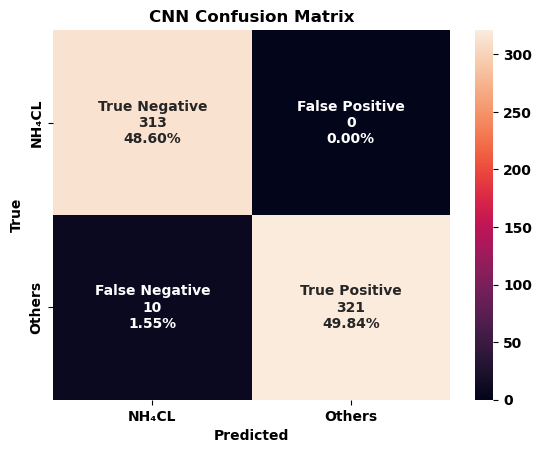

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%pip install seaborn
import seaborn as sns
labels = ['NH\u2084CL', "Others",]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# sns.heatmap(cm, annot=True)
# disp.plot(cmap=plt.cm.Blues)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.title('CNN Confusion Matrix')

# plt.savefig('cnn.png')

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
label = ['NH\u2084CL', "Others",]
sns.heatmap(cm, annot=labels, fmt='',xticklabels=label, yticklabels=label)
plt.title('CNN Confusion Matrix',fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('cnn.png')
plt.show()

21/21 [==============================] - 10s 448ms/step


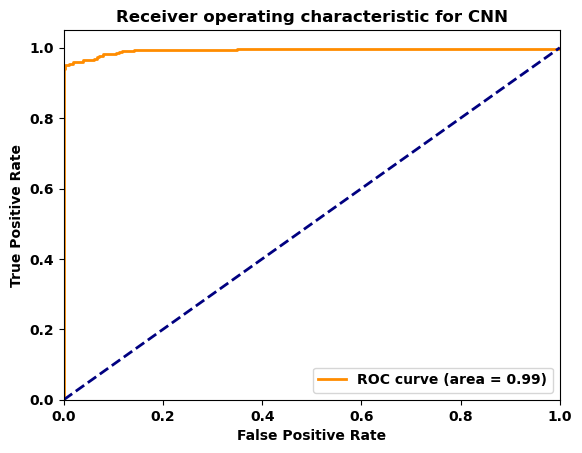

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
model.evaluate(validation_set)



STEP_SIZE_TEST=validation_set.n//validation_set.batch_size
validation_set.reset()
preds=model.predict(validation_set)
preds

fpr, tpr, _ = roc_curve(validation_set.classes,  preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN',fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('RocCNN.png')
plt.show()


In [37]:
roc_auc_score(validation_set.classes, preds[:,1])

0.992905610841385

In [10]:
 preds[:,1]

array([0.32723153, 0.0668874 , 0.19190808, 0.07241379, 0.15397763,
       0.15929991, 0.09785174, 0.1237606 , 0.10327301, 0.20070255,
       0.23975432, 0.15849565, 0.2132569 , 0.15306759, 0.05732471,
       0.20846264, 0.10652569, 0.15409096, 0.1202589 , 0.20985514,
       0.20041811, 0.20250905, 0.19079444, 0.10171445, 0.1459237 ,
       0.12707984, 0.18203782, 0.13873127, 0.1383622 , 0.17623593,
       0.20742211, 0.17907722, 0.10303432, 0.11412326, 0.09466238,
       0.09912632, 0.04748931, 0.10641097, 0.10218636, 0.12580925,
       0.12585981, 0.18909112, 0.10957593, 0.08952745, 0.10689747,
       0.14524403, 0.09371589, 0.06104841, 0.15375692, 0.12221716,
       0.10045107, 0.08758222, 0.08718806, 0.11334521, 0.09428586,
       0.07630946, 0.07576915, 0.09208248, 0.04585378, 0.06414112,
       0.07688118, 0.05902687, 0.06536566, 0.09994727, 0.08937419,
       0.07929417, 0.06938918, 0.07096975, 0.05091722, 0.07072148,
       0.07096365, 0.07237355, 0.06645127, 0.129422  , 0.06367

In [13]:
import tensorflow as tf
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False
)

x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
predictions = tf.keras.layers.Dense(
    int(len(training_set.class_indices.keys())),
    activation='softmax'
)(x)

resnet50_model = tf.keras.models.Model(
    inputs= resnet_model.input, 
    outputs=predictions
)

resnet50_model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
    metrics=['accuracy']
)

resnet_history = resnet50_model.fit_generator(
    training_set, 
    epochs=15, 
    shuffle=True, 
    verbose=1,
    validation_data=validation_set
)

/tmp/ipykernel_1703498/35994449.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_history = resnet50_model.fit_generator(


Epoch 1/15
81/81 [==============================] - 171s 2s/step - loss: 0.2929 - accuracy: 0.9027 - val_loss: 0.6950 - val_accuracy: 0.4689
Epoch 2/15
81/81 [==============================] - 164s 2s/step - loss: 0.0823 - accuracy: 0.9911 - val_loss: 0.7757 - val_accuracy: 0.5140
Epoch 3/15
81/81 [==============================] - 164s 2s/step - loss: 0.0565 - accuracy: 0.9930 - val_loss: 0.9732 - val_accuracy: 0.5140
Epoch 4/15
81/81 [==============================] - 164s 2s/step - loss: 0.0399 - accuracy: 0.9926 - val_loss: 1.1566 - val_accuracy: 0.5140
Epoch 5/15
81/81 [==============================] - 164s 2s/step - loss: 0.0326 - accuracy: 0.9942 - val_loss: 1.1563 - val_accuracy: 0.5140
Epoch 6/15
81/81 [==============================] - 164s 2s/step - loss: 0.0296 - accuracy: 0.9946 - val_loss: 1.2332 - val_accuracy: 0.5140
Epoch 7/15
81/81 [==============================] - 164s 2s/step - loss: 0.0280 - accuracy: 0.9953 - val_loss: 1.2244 - val_accuracy: 0.5140
Epoch 8/15
81

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = resnet50_model.predict_generator(validation_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_set.classes, y_pred)
print('Classification Report')
target_names = ['NH4CL', 'Others']
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

/tmp/ipykernel_1703498/2558907357.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = resnet50_model.predict_generator(validation_set)


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       NH4CL       0.97      1.00      0.98       313
      Others       1.00      0.97      0.98       331

    accuracy                           0.98       644
   macro avg       0.98      0.98      0.98       644
weighted avg       0.98      0.98      0.98       644



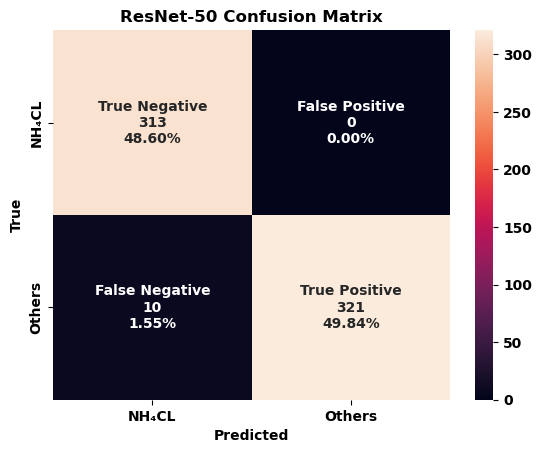

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
labels = ['NH\u2084CL', "Others",]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


# sns.heatmap(cm, annot=True)
# disp.plot(cmap=plt.cm.Blues)
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
# plt.title('CNN Confusion Matrix')

# plt.savefig('cnn.png')

group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
label=['NH\u2084CL', "Others",]
sns.heatmap(cm, annot=labels, fmt='',xticklabels=label, yticklabels=label)
plt.title('ResNet-50 Confusion Matrix',fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('resnet50.png')
plt.show()

21/21 [==============================] - 10s 455ms/step


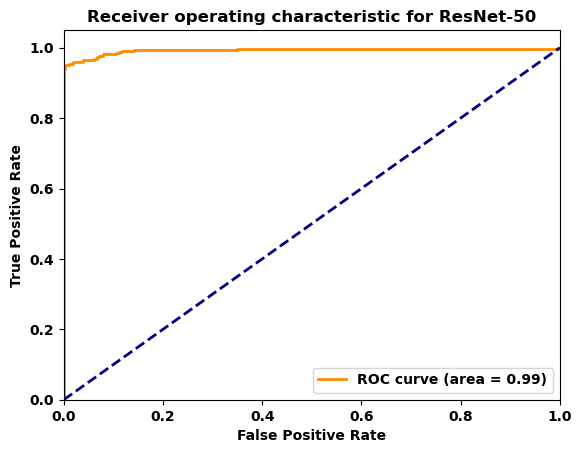

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
model.evaluate(validation_set)



STEP_SIZE_TEST=validation_set.n//validation_set.batch_size
validation_set.reset()
preds=model.predict(validation_set)
preds
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
fpr, tpr, _ = roc_curve(validation_set.classes,  preds[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for ResNet-50',fontweight='bold')
plt.legend(loc="lower right")
plt.savefig('Rocresnet50.png')
plt.show()

In [38]:
roc_auc_score(validation_set.classes, preds[:,1])

0.992905610841385